# Trail 0: Generation on TATDQA (sample)

## Creating Dataset

In [1]:
from datasets import load_dataset
from docrag.datasets import (
    CorpusIndex,
    project_fields,
    add_images_column,
)

In [2]:
# Load MPDocVQA unified dataset
qa_ds = load_dataset("AHS-uni/tatdqa-qa-sample")
corpus_ds = load_dataset("AHS-uni/tatdqa-corpus-sample")

In [3]:
qa_ds["train"].features

{'id': Value(dtype='string', id=None),
 'question': {'id': Value(dtype='string', id=None),
  'text': Value(dtype='string', id=None),
  'type': ClassLabel(names=['extractive', 'verification', 'counting', 'arithmetic', 'abstractive', 'procedural', 'reasoning', 'other'], id=None),
  'tags': [{'name': ClassLabel(names=['missing', 'low_quality', 'inferred', 'predicted'], id=None),
    'target': Value(dtype='string', id=None),
    'comment': Value(dtype='string', id=None)}]},
 'document': {'id': Value(dtype='string', id=None),
  'type': ClassLabel(names=['legal', 'financial', 'scientific', 'technical', 'policy', 'correspondence', 'marketing', 'personal_record', 'news', 'other'], id=None),
  'count_pages': Value(dtype='int32', id=None),
  'tags': [{'name': ClassLabel(names=['missing', 'low_quality', 'inferred', 'predicted'], id=None),
    'target': Value(dtype='string', id=None),
    'comment': Value(dtype='string', id=None)}]},
 'evidence': {'pages': Sequence(feature=Value(dtype='int32', id=

In [4]:
corpus_ds["train"].features

{'document_id': Value(dtype='string', id=None),
 'page_number': Value(dtype='int32', id=None),
 'image': Image(mode=None, decode=True, id=None)}

In [5]:
# Build corpus index
corpus_index = CorpusIndex(corpus_ds["train"])

In [6]:
corpus_ds["train"][7]

{'document_id': '5ad129a7811eecc376281f624eb26150',
 'page_number': 0,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2475x3225>}

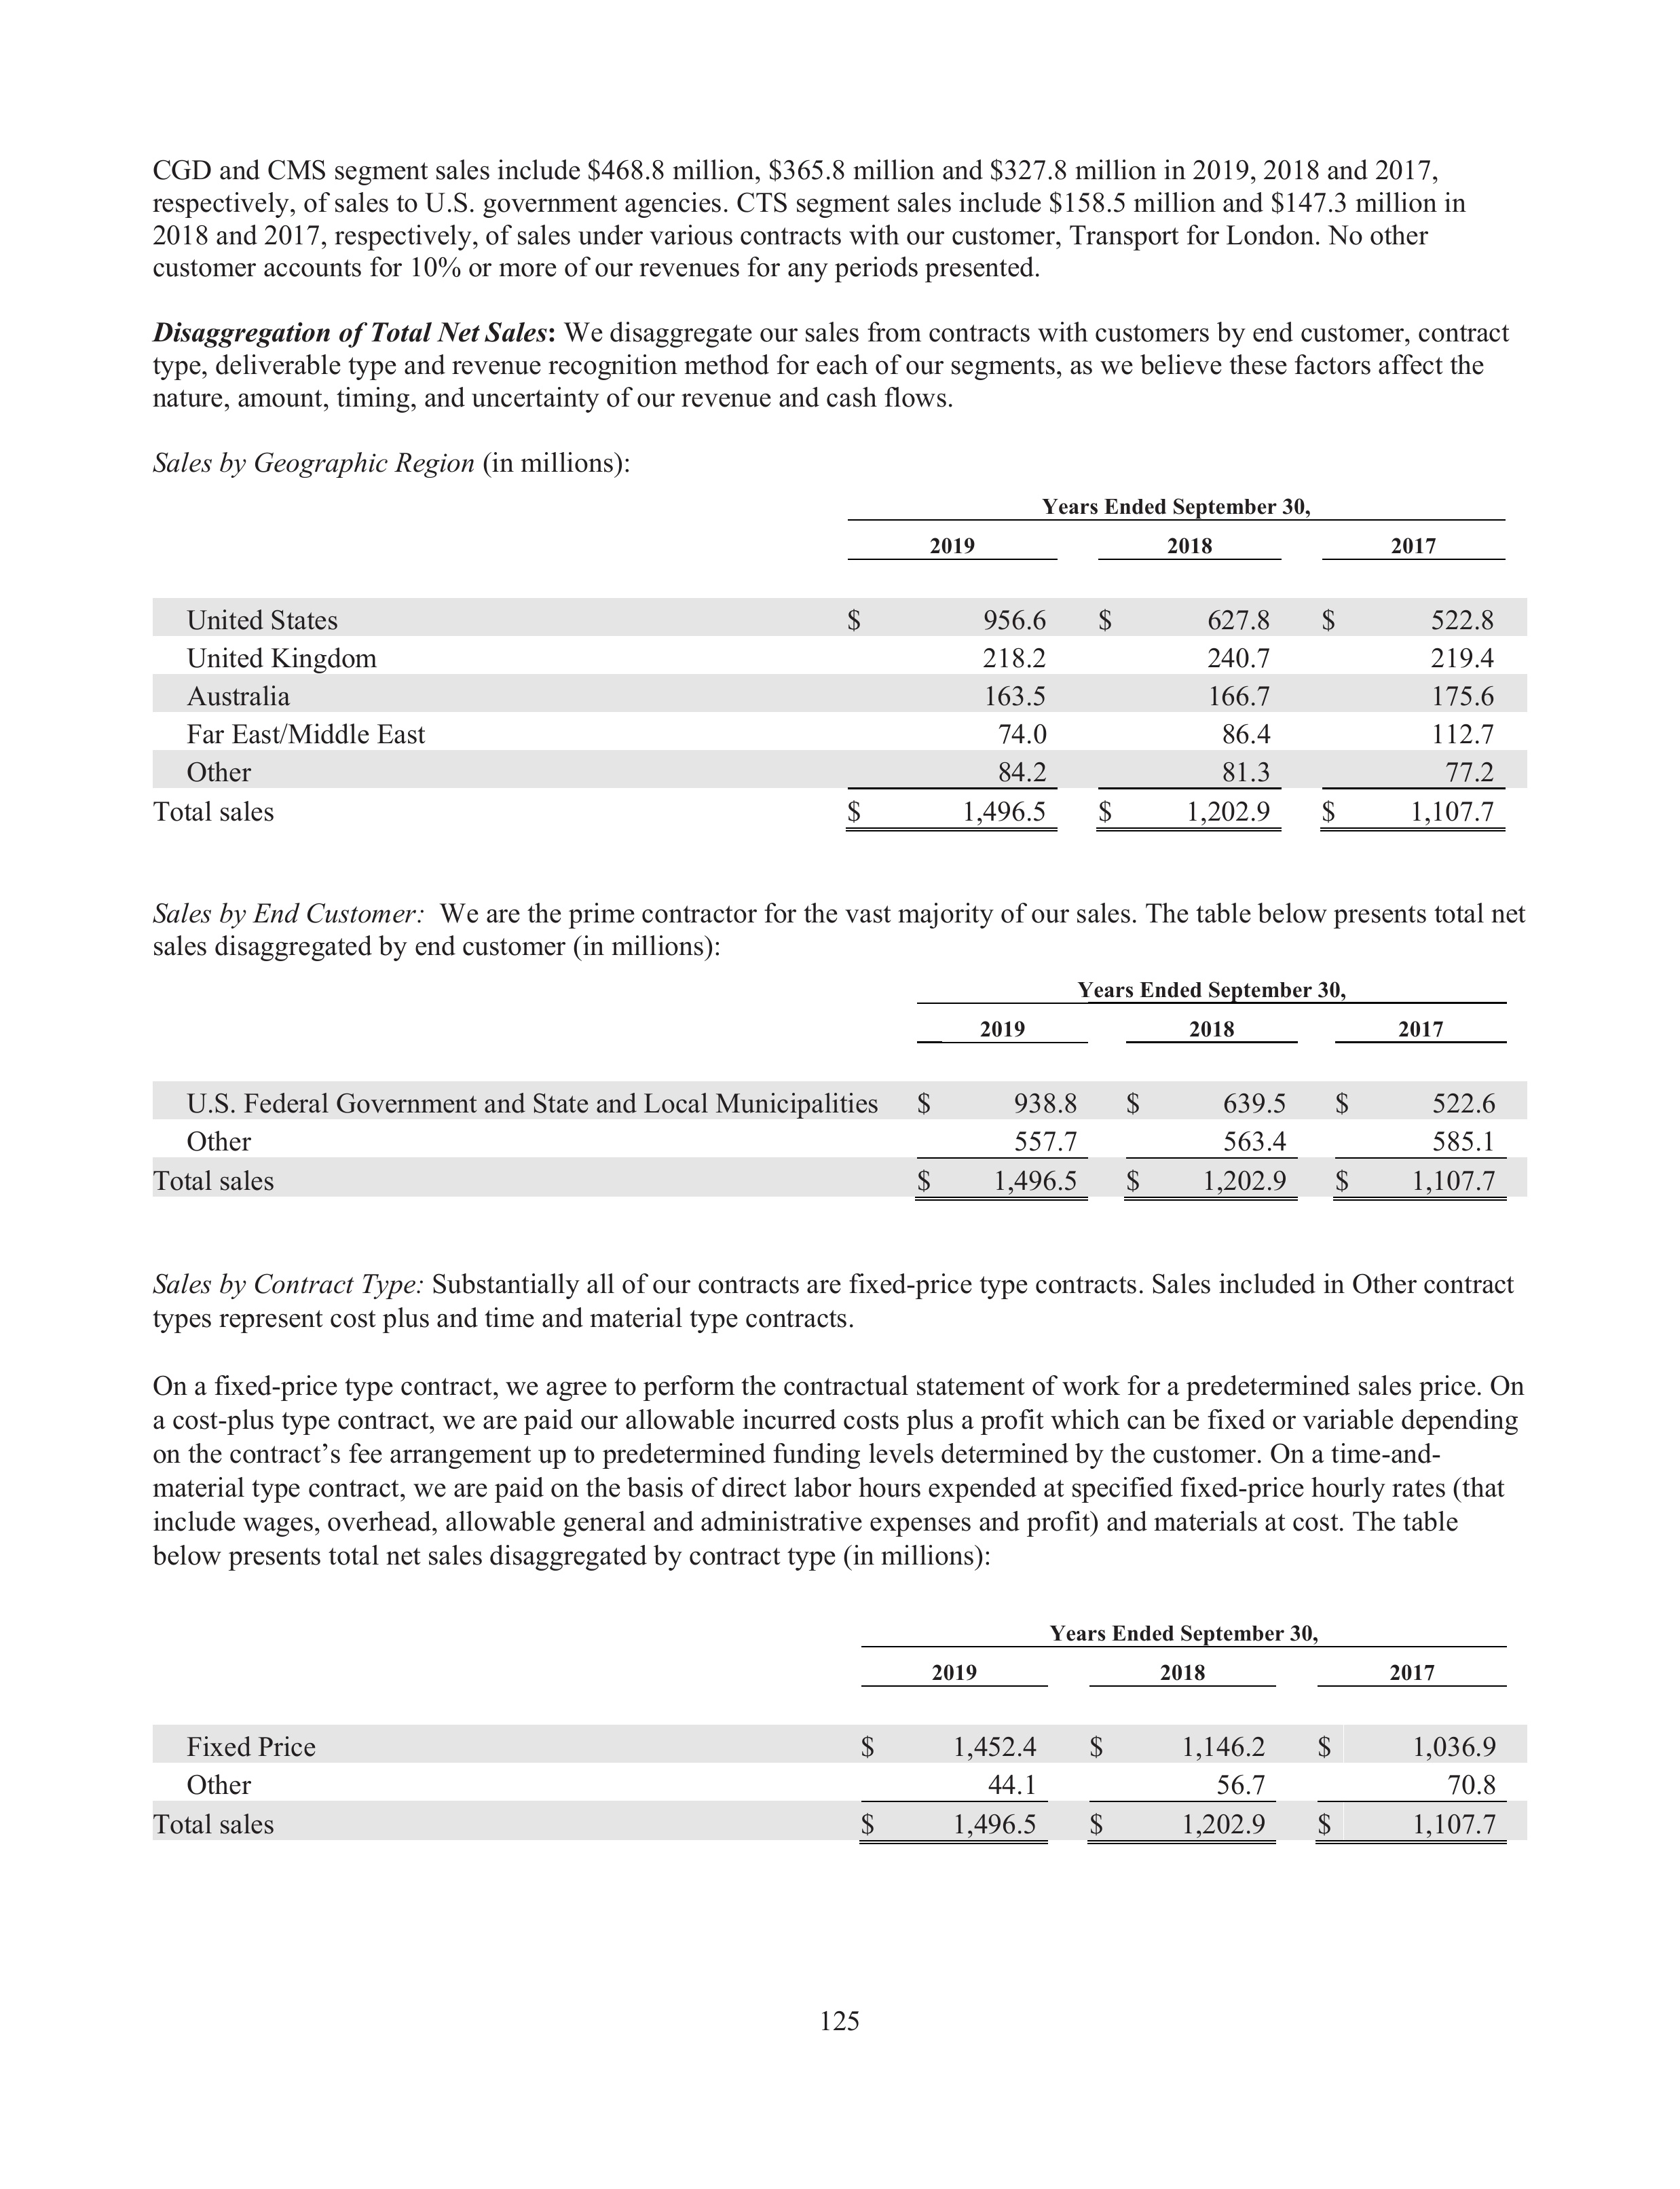

In [7]:
display(corpus_index.get_page("5ad129a7811eecc376281f624eb26150", 0))

In [8]:
# Perform transforms

select_fields = {
    "id": "id",
    "document": "document.id",
    "question": "question.text",
    "evidence": "evidence.pages",
    "answers": "answer.variants",
}

vqa_ds = project_fields(qa_ds["train"], select_fields=select_fields)

vqa_ds = add_images_column(
    vqa_ds,
    corpus_index,
    mode="evidence_pages",
    document_id_path="document",
    evidence_pages_path="evidence",
)

In [9]:
vqa_ds

Dataset({
    features: ['id', 'document', 'question', 'evidence', 'answers', 'images'],
    num_rows: 36
})

In [10]:
vqa_ds.features

{'id': Value(dtype='string', id=None),
 'document': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'evidence': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'images': [Image(mode=None, decode=True, id=None)]}

## Inference Function

In [11]:
import json
import io
import time
from pathlib import Path
from typing import Any

from PIL import Image
from datasets import Dataset

from docrag.generation import Generator

In [12]:
def run_inference(
    generator: Generator,
    dataset: Dataset,
    output_path: Path,
    text_field: str = "text",
    image_field: str = "images",
) -> None:
    """
    Run inference using Generator on a HuggingFace dataset and save results.

    Args:
        generator (Generator): Configured generator to use for inference.
        dataset (Dataset): HuggingFace dataset.
        output_path (Path): Path to output JSON file.
        text_field (str): Name of the field containing input text.
        image_field (str): Name of the field containing image(s).
    """
    results: list[dict[str, str]] = []

    for _, example in enumerate(dataset):
        text = example[text_field]
        images = example[image_field]
        
        start_time = time.perf_counter()
        output = generator.generate(images=images, text=text)
        end_time = time.perf_counter()

        generation_time = end_time - start_time

        results.append({
            "id": example["id"],
            "text": text,
            "model_output": output,
            "ground_truth": example["answers"],
            "generation_time": generation_time,
        })

    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_path.write_text(json.dumps(results, indent=2, ensure_ascii=False))

## Generator: Qwen 2.5 VL

In [13]:
from docrag.schema.config import (
    TokenizerConfig,
    ImageProcessorConfig,
    GenerationConfig,
    ModelConfig,
    GeneratorConfig,
)

In [14]:
# Basic settings
qwen_config = GeneratorConfig(
    model=ModelConfig(
        name="qwen2.5-vl",
        path="Qwen/Qwen2.5-VL-3B-Instruct",
        dtype="bfloat16",
        device="cuda",
        trust_remote_code=True,
        device_map="auto",
        attn_implementation="flash_attention_2",
    ),
    image_processor=ImageProcessorConfig(
        normalize=True,
        extra={
            "min_pixels": 256 * 28 * 28,
            "max_pixels": 1280 * 28 * 28,
        }
    ),
    generation=GenerationConfig(
        max_new_tokens=128,
        temperature=0.7,
    ),
    prompt_template="Question: {text}. Answer:",
    system_prompt="You are a helpful vision-language assistant. You will be shown an image and a user question. Your task is to answer the question as briefly and accurately as possible using only the information visible in the image. Do not add explanations or extra details. If the answer is not present in the provided document or unclear, respond with 'Not Answerable'.",
)

### Model Loading

In [15]:
qwen_generator = Generator(qwen_config)

In [16]:
# Initializing the model
qwen_generator.init_adapter()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


## Inference Run \#0

In [17]:
run_inference(
    generator=qwen_generator,
    dataset=vqa_ds,
    output_path="results_0.json",
    text_field="question",
    image_field="images",
)

## Generator: InternVL

In [24]:
# Basic settings
internvl_config = GeneratorConfig(
    model=ModelConfig(
        name="internvl3",
        path="OpenGVLab/InternVL3-2B-hf",
        dtype="bfloat16",
        device="cuda",
        trust_remote_code=True,
        device_map="auto",
    ),
    image_processor=ImageProcessorConfig(
        normalize=True,
    ),
    generation=GenerationConfig(
        max_new_tokens=128,
        temperature=0.7,
    ),
    prompt_template="Question: {text}. Answer:",
    system_prompt="You are a helpful vision-language assistant. You will be shown an image and a user question. Your task is to answer the question as briefly and accurately as possible using only the information visible in the image. Do not add explanations or extra details. If the answer is not present in the provided document or unclear, respond with 'Not Answerable'.",
)

### Model Loading

In [26]:
internvl_generator = Generator(internvl_config)

In [27]:
internvl_generator.init_adapter()

config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/481 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.86k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

## Inference Run \#1

In [28]:
run_inference(
    generator=internvl_generator,
    dataset=vqa_ds,
    output_path="results_1.json",
    text_field="question",
    image_field="images",
)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_i

In [19]:
##del qwen_generator

In [20]:
gc.collect()  # Force garbage collection
torch.cuda.empty_cache()

In [21]:
import os
print(os.getcwd())


/workspace/docrag/trials/generation


In [22]:
vqa_ds[7]["question"]

'What is the Balance at beginning of year for Year ended march 29, 2019? '

In [23]:
qwen_generator

NameError: name 'qwen_generator' is not defined